# Исследование аренды велосипедов в Нью-Йорке. Citibike за сентябрь-октябрь 2022

**Задачи:** 
* Сделать исследовательский анализ данных велопроката в Нью-Йорке (США) за сентябрь-октябрь 2022 года. 
* Исследовать корреляции с внешними данными. 
* Построить дашборд в DataLens с основными показателями и выводами

Готовый дашборд с выводами - https://datalens.yandex.ru/3oe7x2bnzxtcu-dashboard-ny-bike?tab=1M

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mysql-connector-python
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.5 MB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

import geopy.distance

from sqlalchemy import create_engine
from sqlalchemy import exc
import pymysql

In [ ]:
# Подключение к БД
def db_connect():
  # Connection to MySQL database
  try:
    mydb = create_engine("mysql+pymysql://")
    print("Connected mysql")
    return mydb
  except exc.SQLAlchemyError as e:
    print(type(e))
    return false

# Citibike

In [ ]:
# Импортируем в цикле несколько датасетов за разные месяцы
data = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/Data analyst/ride/JC*.csv"))))
data.shape

(193805, 13)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193805 entries, 0 to 89557
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             193805 non-null  object 
 1   rideable_type       193805 non-null  object 
 2   started_at          193805 non-null  object 
 3   ended_at            193805 non-null  object 
 4   start_station_name  193805 non-null  object 
 5   start_station_id    193805 non-null  object 
 6   end_station_name    193097 non-null  object 
 7   end_station_id      193097 non-null  object 
 8   start_lat           193805 non-null  float64
 9   start_lng           193805 non-null  float64
 10  end_lat             193481 non-null  float64
 11  end_lng             193481 non-null  float64
 12  member_casual       193805 non-null  object 
dtypes: float64(4), object(9)
memory usage: 20.7+ MB


In [ ]:
# Переводим колонки в дату и время
data['started_at'] =  pd.to_datetime(data['started_at'])
data['ended_at'] =  pd.to_datetime(data['ended_at'])
data[['started_at', 'ended_at']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193805 entries, 0 to 89557
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   started_at  193805 non-null  datetime64[ns]
 1   ended_at    193805 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 4.4 MB


In [ ]:
# Рассчитываем длительность поездки в минутах и округляем
data['duration'] = pd.to_datetime(data['ended_at']) - pd.to_datetime(data['started_at'])
data['duration'] = round(data['duration'] / pd.Timedelta('60s'), 2)

In [ ]:
# Создаём колонки с датой старта и окончания, где уберём время
data['start_date'] = pd.to_datetime(data['started_at']).dt.strftime('%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['ended_at']).dt.strftime('%Y-%m-%d')

In [ ]:
data.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration,start_date,end_date
99229,BF2C133D7FF07AFB,classic_bike,2022-09-23 13:47:22,2022-09-23 13:50:52,Grove St PATH,JC005,Van Vorst Park,JC035,40.719586,-74.043117,40.718489,-74.047727,member,3.50,2022-09-23,2022-09-23
43460,E31350AE93FB12E3,classic_bike,2022-10-12 19:44:10,2022-10-12 19:45:58,Newport Pkwy,JC008,Newport PATH,JC066,40.728732,-74.032036,40.727224,-74.033759,member,1.80,2022-10-12,2022-10-12
19751,3D1BF39CA4D4D5AC,classic_bike,2022-09-24 14:11:59,2022-09-24 14:20:46,Madison St & 1 St,HB402,South Waterfront Walkway - Sinatra Dr & 1 St,HB103,40.738705,-74.039165,40.736982,-74.027781,member,8.78,2022-09-24,2022-09-24
11003,6099657CF5BB0F91,classic_bike,2022-09-29 07:56:04,2022-09-29 07:59:30,Jersey & 6th St,JC027,Grove St PATH,JC005,40.725289,-74.045572,40.719586,-74.043117,member,3.43,2022-09-29,2022-09-29
89479,33FEEEEF31E28FA8,classic_bike,2022-10-12 09:13:49,2022-10-12 09:40:15,Bloomfield St & 15 St,HB203,W 16 St & The High Line,6233.05,40.754530,-74.026580,40.743349,-74.006818,member,26.43,2022-10-12,2022-10-12


In [ ]:
# Проверим на количество дубликатов в данных
print("Дубликатов в датасете:", len(data[data.duplicated(keep=False)]))

Дубликатов в датасете: 0


In [ ]:
# Границы дат
print(data['started_at'].min())
print(data['started_at'].max())

2022-09-01 00:00:43
2022-10-31 23:46:47


In [ ]:
data.describe()

,start_lat,start_lng,end_lat,end_lng,duration
count,193805.000000,193805.000000,193481.000000,193481.000000,193805.000000
mean,40.732420,-74.040151,40.732397,-74.039944,15.902311
std,0.012067,0.012084,0.012185,0.012120,129.048480
min,40.706495,-74.088964,40.650000,-74.120000,-0.150000
25%,40.721492,-74.045953,40.721124,-74.045572,4.430000
50%,40.735208,-74.037683,40.735208,-74.037683,6.980000
75%,40.742258,-74.030970,40.742258,-74.030970,11.500000
max,40.754992,-74.023726,40.849972,-73.931594,27607.070000


В длительности есть выбросы в виде отрицательных и очень больших значений.

In [ ]:
# Смотрим количество отрицательных и на нуле
len(data.query('duration <= 0'))

10

In [ ]:
# Диапазон по перцентилям
np.percentile(data['duration'], [80, 85, 90, 95, 99, 99.9])

array([  13.37,   16.15,   21.25,   34.22,   96.07, 1499.9 ])

99% поездок с длительностью до 96 минут.

90% поездок входят в стандартный пакет до 30 минут, который включен в стоимость.

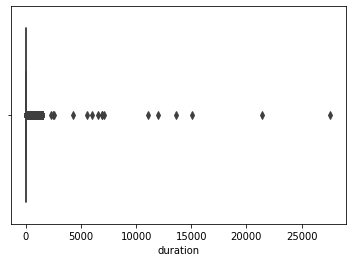

In [ ]:
sns.boxplot(x=data['duration']);

In [ ]:
# Убираем данные с аномально длинными и отрицательными поездками
per1 = np.percentile(data['duration'], [99])
data = data.query('duration > 0 and duration <= @per1')
data.shape

(191858, 16)

Потеряли всего около 2000 записей.

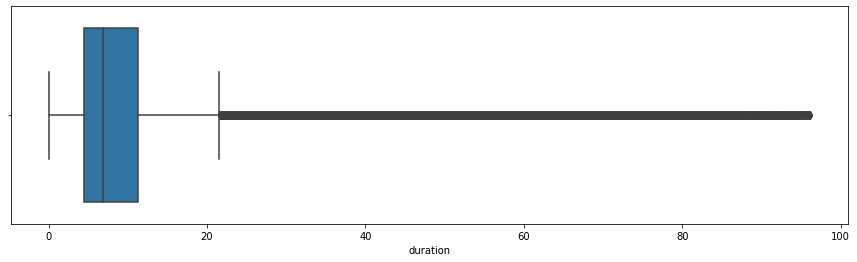

In [219]:
plt.figure(figsize=(15, 4));
sns.boxplot(x=data['duration']);

Общая медиана длительности поездки - меньше 10 минут. 

# Запись в БД

In [ ]:
# Если ещё не подключались - подключаемся к базе
if 'mydb' not in globals():
  mydb = db_connect()

In [ ]:
# Добавление строк в таблицу
if mydb:
  data.to_sql(con=mydb, name='ride', if_exists='replace')

In [ ]:
# Формируем отдельные таблицы (старта и окончания) через sql-запросы
start_station = pd.read_sql('''SELECT start_station_id,
                                      start_station_name,
                                      start_lat,
                                      start_lng,
                                      COUNT(*) AS count_ride
                              FROM ride 
                              GROUP BY start_station_id
                              ORDER BY count_ride DESC''', mydb)


end_station = pd.read_sql('''SELECT end_station_id,
                                      end_station_name,
                                      end_lat,
                                      end_lng,
                                      COUNT(*) AS count_ride
                              FROM ride 
                              GROUP BY end_station_id
                              ORDER BY count_ride DESC''', mydb)

In [ ]:
# Формируем таблицу с популярными маршрутами
path = pd.read_sql('''SELECT CONCAT(start_station_id, ' - ', end_station_id) AS path,
                             start_station_name,
                             end_station_name,
                             start_lat,
                             start_lng,
                             end_lat,
                             end_lng,
                             COUNT(*) AS count_path
                      FROM ride
                      GROUP BY path
                      ORDER BY count_path DESC
               ''', mydb)

# Считаем дистанцию от начальной и конченой точки по координатам (в км)
for i in range(len(path)):
  coords_1 = (path['start_lat'][i], path['start_lng'][i])
  coords_2 = (path['end_lat'][i], path['end_lng'][i])
  path.loc[i, 'distance'] = geopy.distance.geodesic(coords_1, coords_2).km

path.head()

,path,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,count_path,distance
0,HB101 - JC105,Hoboken Terminal - Hudson St & Hudson Pl,Hoboken Ave at Monmouth St,40.735938,-74.030305,40.735208,-74.046964,1221,1.409539
1,JC005 - JC013,Grove St PATH,Marin Light Rail,40.719586,-74.043117,40.714584,-74.042817,924,0.556053
2,JC013 - JC005,Marin Light Rail,Grove St PATH,40.714584,-74.042817,40.719586,-74.043117,907,0.556053
3,JC105 - HB101,Hoboken Ave at Monmouth St,Hoboken Terminal - Hudson St & Hudson Pl,40.735225,-74.046938,40.735938,-74.030305,906,1.407235
4,HB201 - HB103,12 St & Sinatra Dr N,South Waterfront Walkway - Sinatra Dr & 1 St,40.750604,-74.024020,40.736982,-74.027781,811,1.545684


In [ ]:
# Записываем в базу данных
if mydb:
  start_station.to_sql(con=mydb, name='start_station', if_exists='replace')
  end_station.to_sql(con=mydb, name='end_station', if_exists='replace')
  path.to_sql(con=mydb, name='path', if_exists='replace')

# Погода

Обогатим данные погодой, чтобы поискать корреляции. Закажем архив в официальной службе погоды NY.

In [ ]:
# Скачиваем датасет с официальных источников
weather = pd.read_csv('/content/drive/MyDrive/Data analyst/ride/weatherny.csv')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    669 non-null    object 
 1   NAME       669 non-null    object 
 2   LATITUDE   669 non-null    float64
 3   LONGITUDE  669 non-null    float64
 4   ELEVATION  669 non-null    float64
 5   DATE       669 non-null    object 
 6   AWND       652 non-null    float64
 7   PGTM       0 non-null      float64
 8   PRCP       669 non-null    float64
 9   SNOW       669 non-null    float64
 10  SNWD       669 non-null    float64
 11  TAVG       0 non-null      float64
 12  TMAX       669 non-null    float64
 13  TMIN       669 non-null    float64
 14  TSUN       2 non-null      float64
 15  WDF2       653 non-null    float64
 16  WDF5       647 non-null    float64
 17  WSF2       653 non-null    float64
 18  WSF5       647 non-null    float64
dtypes: float64(16), object(3)
memory usage: 99.4+ KB


**Описание колонок:**

* Precipitation (PRCP), tenths of mm
* Snow depth (SNWD)
* Snowfall (SNOW), (mm)
* Total sunshine for the period (TSUN)
* Average Temperature, C (TAVG)
* Maximum temperature, C (TMAX)
* Minimum temperature, C (TMIN)
* Average wind speed, tenths of meters per second (AWND)
* Direction of fastest 2-minute wind, degrees (WDF2)
* Direction of fastest 5-second wind, degrees (WDF5)
* Fastest 2-minute wind speed, tenths of meters per second (WSF2)
* Fastest 5-second wind speed, tenths of meters per second (WSF5)
* Peak gust time (PGTM)

In [ ]:
# Для удобства переводим названия колонок в нижний регистр
weather.columns = map(str.lower, weather.columns)
weather.sample(5)

,name,latitude,longitude,date,awnd,prcp,snow,snwd,tmax,tmin,wdf2,wdf5,wsf2,wsf5,tavg
494,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,2022-05-10,4.5,0.0,0.0,0.0,22.8,10.6,50.0,50.0,10.3,13.4,16.7
3,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,2021-01-04,2.0,0.5,0.0,0.0,6.1,1.7,30.0,40.0,5.4,8.1,3.9
192,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,2021-07-12,2.2,36.1,0.0,0.0,30.0,22.2,60.0,50.0,6.3,8.9,26.1
253,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,2021-09-11,0.9,0.0,0.0,0.0,24.4,15.6,250.0,260.0,4.5,10.7,20.0
664,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,2022-10-27,3.0,0.0,0.0,0.0,18.3,11.1,20.0,360.0,6.3,10.3,14.7


In [ ]:
# Границы дат
print(weather['date'].min())
print(weather['date'].max())

2021-01-01
2022-10-31


In [ ]:
# Убираем колонки с нулевыми значениями
weather = weather.drop(['station', 'elevation', 'pgtm', 'tavg', 'tsun'], axis=1)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       669 non-null    object 
 1   latitude   669 non-null    float64
 2   longitude  669 non-null    float64
 3   date       669 non-null    object 
 4   awnd       652 non-null    float64
 5   prcp       669 non-null    float64
 6   snow       669 non-null    float64
 7   snwd       669 non-null    float64
 8   tmax       669 non-null    float64
 9   tmin       669 non-null    float64
 10  wdf2       653 non-null    float64
 11  wdf5       647 non-null    float64
 12  wsf2       653 non-null    float64
 13  wsf5       647 non-null    float64
dtypes: float64(12), object(2)
memory usage: 73.3+ KB


In [ ]:
# Проверим на количество дубликатов в данных
print("Дубликатов в датасете:", len(weather[weather.duplicated(keep=False)]))

Дубликатов в датасете: 0


In [ ]:
weather.describe()

,latitude,longitude,awnd,prcp,snow,snwd,tmax,tmin,wdf2,wdf5,wsf2,wsf5,tavg
count,6.690000e+02,669.00000,652.000000,669.000000,669.000000,669.000000,669.000000,669.000000,653.000000,647.000000,653.000000,647.000000,669.000000
mean,4.077898e+01,-73.96925,2.278834,3.686099,1.742900,8.116592,18.325859,10.372347,196.768760,194.418856,6.254824,9.887172,14.349103
std,7.110744e-15,0.00000,1.076825,11.574083,18.262465,39.145569,9.926489,9.201616,101.474422,97.779903,1.893036,3.116952,9.460457
min,4.077898e+01,-73.96925,0.400000,0.000000,0.000000,0.000000,-6.000000,-12.100000,10.000000,10.000000,2.700000,4.000000,-9.050000
25%,4.077898e+01,-73.96925,1.400000,0.000000,0.000000,0.000000,10.600000,3.300000,70.000000,110.000000,4.500000,7.600000,6.650000
50%,4.077898e+01,-73.96925,2.100000,0.000000,0.000000,0.000000,20.000000,10.600000,230.000000,220.000000,5.800000,9.400000,15.000000
75%,4.077898e+01,-73.96925,2.900000,1.800000,0.000000,0.000000,26.700000,18.300000,290.000000,280.000000,7.200000,11.600000,22.500000
max,4.077898e+01,-73.96925,6.400000,181.100000,376.000000,360.000000,36.700000,26.100000,360.000000,360.000000,13.000000,21.900000,30.850000


Осадков, а в особенности снега, почти нет.

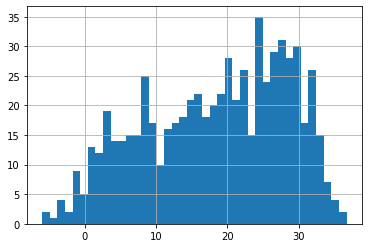

In [ ]:
# Распределение макс. температуры
weather.tmax.hist(bins=40);

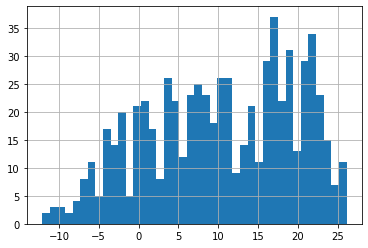

In [ ]:
# Распределение мин. температуры
weather.tmin.hist(bins=40);

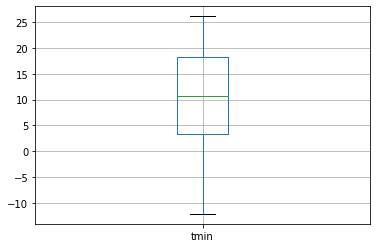

In [ ]:
weather.boxplot('tmin');

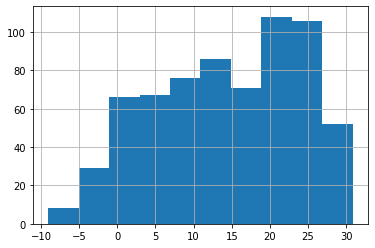

In [ ]:
# Создаём колонку со средней температурой и смотрим распределение
weather['tavg'] = (weather['tmax'] + weather['tmin']) / 2
weather['tavg'].hist();

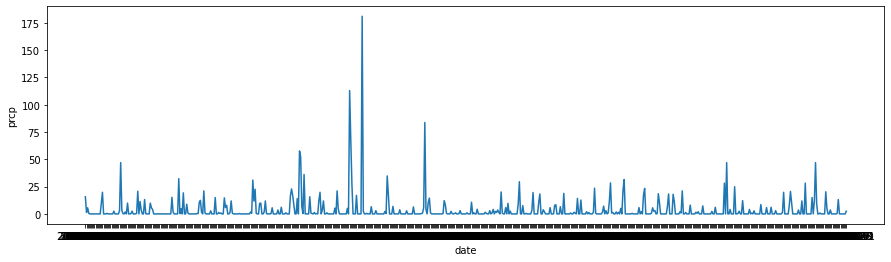

In [ ]:
# Осадки
plt.figure(figsize=(15, 4));
sns.lineplot(data=weather, x='date', y='prcp');

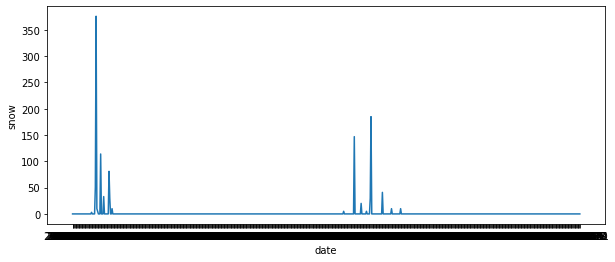

In [ ]:
# Снег
plt.figure(figsize=(10, 4));
sns.lineplot(data=weather, x='date', y='snow');

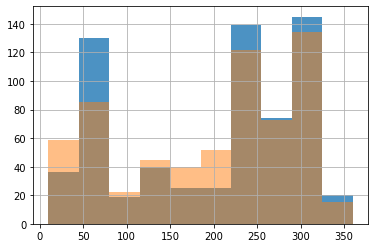

In [ ]:
# Направление ветра в промежутке 2 минут и 5 секунд
weather['wdf2'].hist(alpha=0.8);
weather['wdf5'].hist(alpha=0.5);

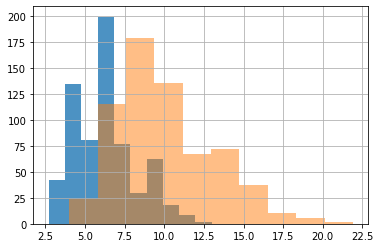

In [ ]:
# Скорость ветра в промежутке 2 минут и 5 секунд
weather['wsf2'].hist(alpha=0.8);
weather['wsf5'].hist(alpha=0.5);

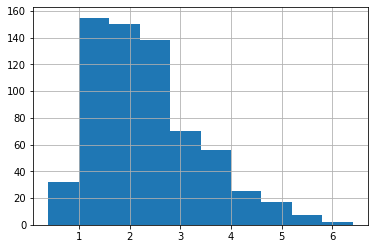

In [ ]:
# Средняя скорость ветра в м/с
weather['awnd'].hist();

In [ ]:
# Создадим сводную таблицу с группировкой по дням. Посчитаем количество поездок и среднюю продолжительность
data_count = data.pivot_table(index=['start_date'], 
                              columns=['member_casual'], 
                              values=['ride_id', 'duration'], 
                              aggfunc={'ride_id':'count', 'duration':'mean'}).reset_index()

# Создадим столбцы с общими показателями
data_count.columns = ['start_date', 'casual_duration', 'member_duration', 'casual_count', 'member_count']
data_count['count'] = data_count['casual_count'] + data_count['member_count']
data_count['duration'] = (data_count['casual_duration'] + data_count['member_duration']) / 2

# Присоединим данные о погоде
data_count = data_count.merge(weather, how='left', left_on='start_date', right_on='date')
# Уберём лишнее
data_count = data_count.drop(['latitude', 'longitude', 'name', 'date'], axis=1)
data_count.head()

,start_date,casual_duration,member_duration,casual_count,member_count,count,duration,awnd,prcp,snow,snwd,tmax,tmin,wdf2,wdf5,wsf2,wsf5,tavg
0,2022-09-01,13.819325,8.816727,1259,2542,3801,11.318026,1.8,0.0,0.0,0.0,30.0,20.6,310.0,300.0,6.3,9.4,25.30
1,2022-09-02,15.208177,9.845765,1382,2333,3715,12.526971,1.7,0.0,0.0,0.0,26.1,16.7,50.0,50.0,5.4,7.2,21.40
2,2022-09-03,18.008899,10.448416,1480,1667,3147,14.228657,1.0,0.0,0.0,0.0,27.8,18.3,150.0,120.0,3.1,6.3,23.05
3,2022-09-04,18.446230,10.954201,1406,1490,2896,14.700216,1.2,0.0,0.0,0.0,32.2,21.7,250.0,290.0,4.5,6.3,26.95
4,2022-09-05,18.571291,10.114816,1193,1605,2798,14.343054,0.9,1.5,0.0,0.0,31.1,22.8,180.0,190.0,4.0,7.6,26.95


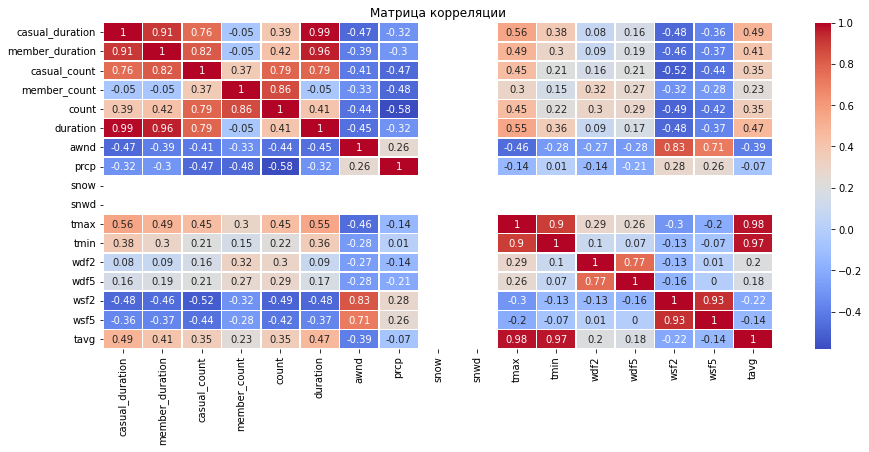

In [ ]:
# Построим матрицу корреляций
plt.figure(figsize=(15, 6));
sns.heatmap(round(data_count.corr(), 2), linewidths=.5, annot = True, cmap='coolwarm').set_title('Матрица корреляции');

`snow` и `snwd` не попали в матрицу. Видимо, из-за небольшого количества снега в сентябре и октябре.

Ср. продолжительность поездок коррелирует со ср. максимальной температурой за день *(r = 0,55)*. Чем теплее на улице днём - тем больше поездок *(0,45)* и ср. продолжительность поездки. Особенно это влияет на тип клиентов casual - корреляция больше на *0,1.*

Имеет значение ср. скорость ветра, особенно макс. за 2 минуты.

Провал **3 октября** коррелирует с пониженной температурой, обильными осадками и сильной скоростью ветра.

Количество осадков (мм) средне коррелирует с количеством поездок *(-0,58)*, но меньше на ср. продолжительность поездки. Все провалы на графике количества поездок - из-за обильных осадков.

# Траффик

Проверим корреляции с трафиком на дорогах. Возьмём [real-time traffic](https://data.beta.nyc/dataset/nyc-real-time-traffic-speed-data-feed-archived).

In [208]:
# Импортируем в цикле несколько датасетов за разные месяцы
traff = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/Data analyst/ride/traffic_*.csv"))))
traff.shape

(2817397, 6)

In [209]:
# Добавим отдельно части дат
traff['DataAsOf'] =  pd.to_datetime(traff['DataAsOf'])
traff['date'] = pd.to_datetime(traff['DataAsOf']).dt.strftime('%Y-%m-%d')
traff['time'] = pd.to_datetime(traff['DataAsOf']).dt.strftime('%H')
traff['year'] = pd.to_datetime(traff['DataAsOf']).dt.strftime('%Y')
#traff['date'] = pd.to_datetime(traff['date'])
traff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2817397 entries, 0 to 1614249
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Id          int64         
 1   Speed       float64       
 2   TravelTime  int64         
 3   Status      object        
 4   DataAsOf    datetime64[ns]
 5   linkId      int64         
 6   date        object        
 7   time        object        
 8   year        object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 215.0+ MB


In [210]:
traff['time'] = traff['time'].astype('int')
traff.sample(5)

,Id,Speed,TravelTime,Status,DataAsOf,linkId,date,time,year
816095,419,0.00,0,-,2021-10-29 16:54:04,4616204,2021-10-29,16,2021
974153,149,21.12,336,0,2022-09-05 15:33:03,4616339,2022-09-05,15,2022
1466339,331,52.81,147,0,2022-09-26 21:11:05,4616353,2022-09-26,21,2022
739280,426,47.22,146,0,2022-09-29 02:39:11,4616272,2022-09-29,2,2022
1341190,261,45.98,93,0,2022-09-23 09:43:03,4616226,2022-09-23,9,2022


In [211]:
# Границы дат
print(traff['date'].min())
print(traff['date'].max())

2021-10-29
2022-10-31


In [212]:
# Усредняем скопрость по датчикам и дням
traff_id = traff.pivot_table(index=['date', 'linkId'], values='Speed', aggfunc='mean').reset_index()
traff_id

,date,linkId,Speed
0,2021-10-29,4616204,0.000000
1,2021-10-29,4616205,0.000000
2,2021-10-29,4616218,0.000000
3,2021-10-29,4616219,0.000000
4,2021-10-29,4763648,0.000000
...,...,...,...
6865,2022-10-31,4620331,29.314181
6866,2022-10-31,4620332,29.404983
6867,2022-10-31,4620343,0.000000
6868,2022-10-31,4763649,0.000000


In [213]:
# Усредняем по дням
traff_day = traff_id.pivot_table(index=['date'], values='Speed', aggfunc='mean').reset_index()
traff_day.head()

,date,Speed
0,2021-10-29,0.000000
1,2022-09-01,31.451836
2,2022-09-02,32.077505
3,2022-09-03,35.288038
4,2022-09-04,35.298188


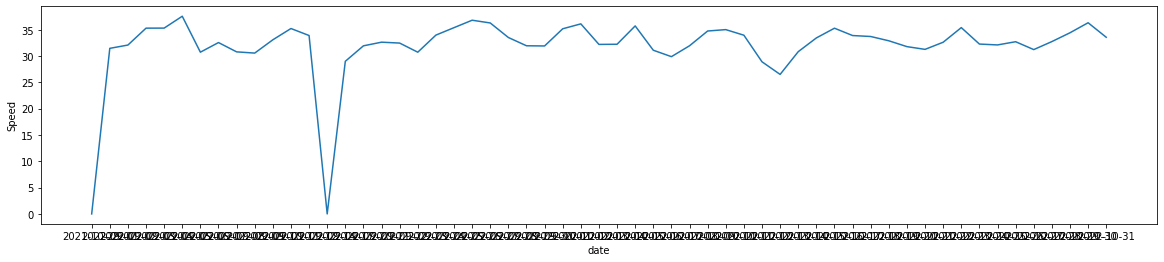

In [214]:
# Ср. скорость во времени
plt.figure(figsize=(20, 4));
sns.lineplot(data=traff_day, x='date', y='Speed');


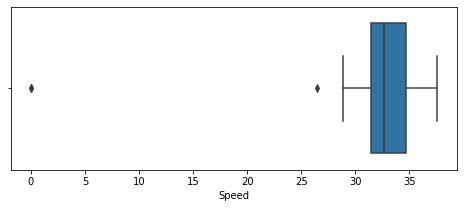

In [216]:
plt.figure(figsize=(8, 3));
sns.boxplot(x=traff_day['Speed']);

In [217]:
# Присоединяем к общей таблице по дням
data_count = data_count.merge(traff_day, how='left', left_on='start_date', right_on='date')
data_count.head()

,start_date,casual_duration,member_duration,casual_count,member_count,count,duration,awnd,prcp,snow,...,tmin,wdf2,wdf5,wsf2,wsf5,tavg,date_x,Speed_x,date_y,Speed_y
0,2022-09-01,13.819325,8.816727,1259,2542,3801,11.318026,1.8,0.0,0.0,...,20.6,310.0,300.0,6.3,9.4,25.30,2022-09-01,28.230977,2022-09-01,31.451836
1,2022-09-02,15.208177,9.845765,1382,2333,3715,12.526971,1.7,0.0,0.0,...,16.7,50.0,50.0,5.4,7.2,21.40,2022-09-02,29.546976,2022-09-02,32.077505
2,2022-09-03,18.008899,10.448416,1480,1667,3147,14.228657,1.0,0.0,0.0,...,18.3,150.0,120.0,3.1,6.3,23.05,2022-09-03,32.965256,2022-09-03,35.288038
3,2022-09-04,18.446230,10.954201,1406,1490,2896,14.700216,1.2,0.0,0.0,...,21.7,250.0,290.0,4.5,6.3,26.95,2022-09-04,33.424074,2022-09-04,35.298188
4,2022-09-05,18.571291,10.114816,1193,1605,2798,14.343054,0.9,1.5,0.0,...,22.8,180.0,190.0,4.0,7.6,26.95,2022-09-05,36.389489,2022-09-05,37.550312


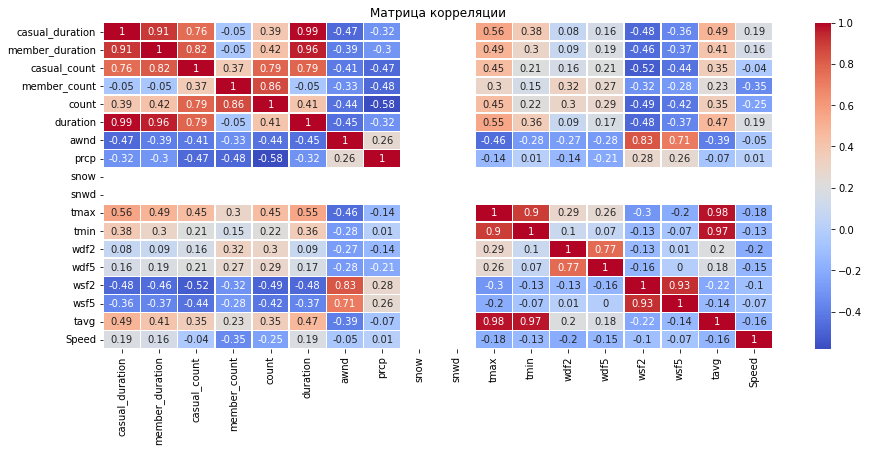

In [126]:
# Строим общую матрицу корреляций, со скоростью
plt.figure(figsize=(15, 6));
sns.heatmap(round(data_count.corr(), 2), linewidths=.5, annot = True, cmap='coolwarm').set_title('Матрица корреляции');

Источник данных у траффик спорный - с пропущенными днями. К тому же, ср. скорость бралась независимо от местоположения датчиков. Но в один район может быть загружен, а другой нет, а средняя берётся от обоих.

Но даже на этих данных видна слабая отрицательная корреляция между скоростью и количество поездок у member *(r = -0,35)*. На эту связь мог повлиять 3-й фактор - например, плохая погода, в которую предпочитают больше автомобили.

In [ ]:
# Отправляем в базу
mydb = db_connect()

if mydb:
  traff_day.to_sql(con=mydb, name='traffic', if_exists='replace')

Connected mysql


# Проверка гипотез

Проверим гипотезы о среднем на стат. значимость.

## Гипотеза 1

**Нулевая гипотеза**: средняя длительность аренды между типами клиентов (`member` и `casual`) не различаются.<br />
**Альтернативная гипотеза**: средняя длительность аренды между группами различаются

In [232]:
# Функция проверки гипотез
def test_hip(data1, data2, alpha = 0.01):
    results = st.mannwhitneyu(data1, data2)

    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
        ) 

In [233]:
test_hip(data_count['member_duration'], data_count['casual_duration'])

p-значение:  5.36443009402627e-19
Отвергаем нулевую гипотезу: разница статистически значима


Итог: Отвергаем нулевую гипотезу - **среднее количество поездок между группами различаются**.

## Гипотеза 2

**Нулевая гипотеза**: среднее количество поездок между типами клиентов (`member` и `casual`) не различаются.<br />
**Альтернативная гипотеза**: среднее количество поездок между группами различаются

In [234]:
test_hip(data_count['member_count'], data_count['casual_count'])

p-значение:  7.351391100159901e-17
Отвергаем нулевую гипотезу: разница статистически значима


Итог: Отвергаем нулевую гипотезу - **среднее количество поездок между группами различаются**.

# Выводы

Интерактивный дашборд по ссылке - https://datalens.yandex/3oe7x2bnzxtcu

**По дням и часам**
* Спрос среди “случайных” (casual) поездок выше в выходные - особенно, в субботу. Видимо, эта когорта больше использует прокат с прогулочно-развлекательной целью.
* Member больше пользуются в рабочие будни.
* Суммарно видно, что пик спроса приходится на на утренние и вечерние часы.
* Но выраженные пики видны у типа клиентов member. Видимо, этот тип клиентов использует велосипеды, как альтернативу транспорта - с работы и обратно. Это доказывает и форма графиков в выходные - разница между типами клиентов практически не видна.
* Casual больше предпочитают электробайки, чем member: 30% против 20%.
* Ср. длительность поездок у casual больше во всех видах, чем у member. Это ещё больше подтверждает гипотезу, что member больше используется как транспорт, а casual - для развлечений и прогулок.
* 99% поездок с длительностью до 96 минут.
* 90% поездок входят в стандартный пакет до 30 минут, который включен в стоимость.
* Средняя продолжительность и количество поездок между группами клиентов (member и casual) - отличаются. Разница статистически значима (p < 0,01)

**Погода**
* Ср. продолжительность поездок коррелирует со ср. максимальной температурой за день (r = 0,55). Чем теплее на улице днём - тем больше поездок (0,45) и ср. продолжительность поездки. Особенно это влияет на тип клиентов casual - корреляция больше на 0,1.

* Имеет значение ср. скорость ветра, особенно макс. за 2 минуты.

* Провал 3 октября коррелирует с пониженной температурой, обильными осадками и сильной скоростью ветра.

* Количество осадков (мм) средне коррелирует с количеством поездок (-0,58), но меньше на ср. продолжительность поездки. Все провалы на графике количества поездок - из-за обильных осадков.


**Трафик**
* Источник данных у траффик спорный - с пропущенными днями. К тому же, ср. скорость бралась независимо от местоположения датчиков. Но в один район может быть загружен, а другой нет, а средняя берётся от обоих.
Но даже на этих данных видна слабая отрицательная корреляция между скоростью и количество поездок у member (r = -0,35). На эту связь мог повлиять 3-й фактор - например, плохая погода, в которую предпочитают больше автомобили.